# Asymptotic Formula Conversion to Python Test

In [169]:
import equadratures as eq
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time

from scipy.special import jn_zeros


In [170]:
def legpts_nodes(a, u, a2, u2, n, vn):
    """Compute nodes using asymptotic formulae."""
    
    # TODO: Include higher-order terms (i.e., F_4 and F_5).
    
    # Assemble coefficients:
    F0 = a
    F1 = 1/8 * (u * a - 1) / a
    if n < 1e4:
        a3 = a ** 3
        F2 = 1/384 * (6 * a2 * (1 + u2) + 25 - u * (31 * u2 + 33) * a3) / a3
    else:
        F2 = 0
    if n < 1e3:
        u4 = u ** 4
        a5 = a ** 5
        R30 = u * (2595 + 6350 * u2 + 3779 * u4) / 15360
        R31 = -(31 * u2 + 11) / 1024
        R32 = u / 512
        R33 = -25 / 3072
        R35 = -1073 / 5120
        F3 = R30 + R35 / a5 + (1 + u2) * (R31 / a + R32 / a2 + R33 / a3)
    else:
        F3 = 0
    
    # The asymptotic expansion for the roots:
    t = F0 + F1 * vn ** 2 + F2 * vn ** 4 + F3 * vn ** 6
    
    # Convert to physical space:
    x = np.cos(t)

    return x, t

In [171]:
def legpts_weights(ua, a, a2, u, u2, n, vn, m):
    """Compute weights using asymptotic formulae."""

    # TODO: Include higher-order terms (i.e., W_4 and W_5).

    # Assemble coefficients:
    W0 = 1
    W1 = 1/8 * (ua + a2 - 1) / a**2
    if n < 1e4:
        a3 = a**3
        a4 = a2**2
        u4 = u**4
        W2 = 1/384 * (81 - 31*ua - 3*(1 - 2*u2)*a2 + 6*u*a3 - (27 + 84*u2 + 56*u4)*a4) / a4
    else:
        W2 = 0
    if n < 1e3:
        u3 = u**3
        u5 = u**5
        u6 = u3**2
        a5 = a**5
        a6 = a3**2
        Q30 = 187/96*u4 + 295/256*u2 + 151/160*u6 + 153/1024
        Q31 = -119/768*u3 -35/384*u5 - 65/1024*u
        Q32 = 5/512 + 7/384*u4 + 15/512*u2
        Q33 = u3/512 - 13/1536*u
        Q34 = -7/384*u2 + 53/3072
        Q35 = 3749/15360*u
        Q36 = -1125/1024
        W3 = Q30 + Q31/a + Q32/a2 + Q33/a3 + Q34/a4 + Q35/a5 + Q36/a6
    else:
        W3 = 0

    # Compute the values of Bessel1(j0k)^2:
    Jk2 = bessel12atj0k(m)

    # The asymptotic expansion for the weights:
    w = 2 / ((np.array(Jk2)/vn**2) * (a/np.sin(a)) * (W0 + W1*vn**2 + W2*vn**4 + W3*vn**6))

    return w

In [172]:
def bessel12atj0k(m):
    """Evaluate besselj(1,x).^2 at roots of besselj(0,x)."""
    m = int(m)
    # Initialise storage:
    Jk2 = np.zeros(m)

    # First 10 values are precomputed (using Wolfram Alpha):
    Jk3 = [0.2695141239419169, 
           0.1157801385822037, 
           0.07368635113640822, 
           0.05403757319811628, 
           0.04266142901724309, 
           0.03524210349099610, 
           0.03002107010305467, 
           0.02614739149530809, 
           0.02315912182469139, 
           0.02078382912226786]

    if m <= 10:
        return Jk3[0:m]
    else:
        Jk2[0:10] = Jk3;
    
    # Use Taylor series of (NIST, 10.17.3) and McMahon's expansion (NIST, 10.21.19):
    k = np.arange(11, m+1)
    ak = np.pi * (k - .25)
    ak2inv = (1./ak)**2
    c = [-171497088497/15206400, 461797/1152, -172913/8064, 151/80, -7/24, 0, 2]

    # Jk2[k] = 1./(np.pi*ak)*np.polyval(c, ak2inv)
    Jk2[k-1] = 1./(np.pi*ak) * (c[6] + ak2inv**2 * (c[4] + ak2inv * (c[3] + 
        ak2inv * (c[2] + ak2inv * (c[1] + ak2inv * c[0])))))

    return Jk2

In [173]:
def asy(n, nout):
    """Compute nodes and weights using asymptotic formulae."""
    
    # Compute roots of BesselJ(0, x);
    m = np.ceil(n/2)
    jk = jn_zeros(0, int(m))

    # Useful values:
    vn = 1. / (n + 0.5)
    a = jk * vn
    u = 1. / np.tan(a)
    ua = u * a
    u2 = u ** 2
    a2 = a ** 2

    # Initialise for storage (so as to only compute once):
    Jk2 = []
    u3 = []; a3 = []
    u4 = []; a4 = []
    u5 = []; a5 = []
    u6 = []; a6 = []

    # Nodes:
    x, t = legpts_nodes(a, u, a2, u2, n, vn)

    # Quadrature weights:
    if nout > 1:
        w = legpts_weights(ua, a, a2, u, u2, n, vn, m)
    else:
        w = []

    # Barycentric weights:
    if nout > 2:
        v = np.sin(t) / np.sqrt(2. / w)
        v = v / v[-1]
    else:
        v = []

    # Use symmetry:
    if n % 2 == 0:
        x = np.concatenate([-x, x[::-1]])
        w = np.concatenate([w, w[::-1]]).T
        v = np.concatenate([v, v[::-1]])
        t = np.concatenate([np.pi - t, t[::-1]])
    else:
        x = np.concatenate([-x[:-1], [0], x[:-2:-1]])
        w = np.concatenate([w[:], w[:-2:-1]]).T
        v = np.concatenate([v[:-1], v[:-2:-1]])
        t = np.concatenate([np.pi - t, t[:-2:-1]])    

    return x, w, v, t

In [174]:
points, weights, v, t = asy(10, 2)

Testing with
$$
F(x) = \int_{-1}^{1}f(x)dx=\int_{-1}^{1}xsin(x^2)dx \\
F(x) = \Bigg[-\frac{cos(x^2)}{2}\Bigg]_{-1}^{\;\,1} = 0 
$$
True value of $F=0$

In [175]:
def f(x):
    return x*np.sin(x**2);

NUM_STEPS = 100
STEP = 1000
xValues = np.linspace(STEP,NUM_STEPS*STEP,NUM_STEPS);

# def errorF(y):
#     return y;
# Error is just equal to value, so unnecessary

In [176]:
fValues = np.zeros(NUM_STEPS);

p_bar = tqdm(range(NUM_STEPS))
for o1 in p_bar:
    p_bar.set_description(f'n = {o1*STEP}')
    points, weights, v, t = asy((o1+1)*STEP, 2);
    points = points.reshape((o1+1)*STEP,1);
    fValues[o1] = float(2*np.dot(weights, eq.evaluate_model(points, f)));


  0%|          | 0/100 [00:00<?, ?it/s]

$$
Error_{F(x)} = F(x) -\sum_{i=1}^{n}f(points_i)*weights_i \\
$$

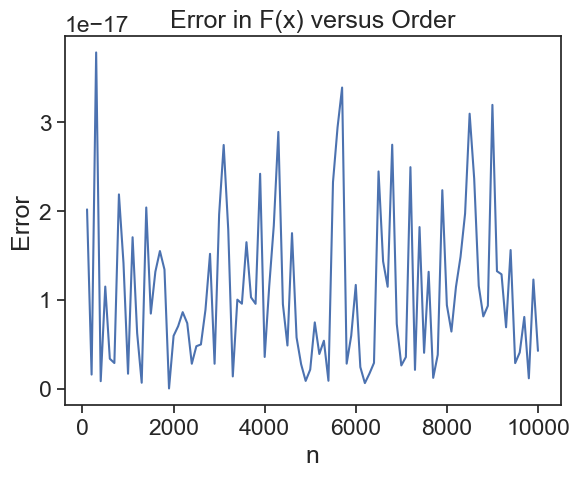

In [177]:
fValues = np.absolute(fValues)
plt.plot(xValues, fValues)
plt.xlabel('n')
plt.ylabel('Error')
plt.title("Error in F(x) versus Order")
plt.show();